<a href="https://colab.research.google.com/github/aim56009/Bias_GAN/blob/master/code/run_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports 

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Jan 27 08:23:25 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
!git clone https://github.com/aim56009/Bias_GAN.git

Cloning into 'Bias_GAN'...
remote: Enumerating objects: 522, done.
remote: Counting objects: 100% (323/323), done.
remote: Compressing objects: 100% (146/146), done.
remote: Total 522 (delta 182), reused 309 (delta 172), pack-reused 199
Receiving objects: 100% (522/522), 98.29 MiB | 15.12 MiB/s, done.
Resolving deltas: 100% (306/306), done.


In [4]:
%%capture
!pip install pytorch_lightning
from pytorch_lightning.loggers import TensorBoardLogger
#TensorBoardLogger("ls")

In [5]:
%%capture
!pip install pytorch_lightning
!pip install basemap
!pip install importlib-metadata==4.0.1
!pip install xarray==0.18.1
!pip install torchvision

In [6]:
from argparse import ArgumentParser
import warnings
warnings.filterwarnings('ignore')
from dataclasses import dataclass, field
from typing import List
import getpass

%load_ext autoreload
%autoreload 2

%matplotlib inline
from Bias_GAN.code.src.utils import show_checkpoints

import os
import xarray as xr
import torch
from IPython.display import Image, display

from Bias_GAN.code.src.model import  DataModule, ConstrainedGenerator
from Bias_GAN.code.src.data import TestData, CycleDataset, ProjectionDataset,  load_cmip6_model, CMIP6Data
from Bias_GAN.code.src.plots import PlotAnalysis
from Bias_GAN.code.src.utils import log_transform, inv_norm_transform, inv_log_transform, inv_norm_minus1_to_plus1_transform, norm_minus1_to_plus1_transform, config_from_file
from Bias_GAN.code.src.projection_utils import ProjectionPreparation
from Bias_GAN.code.src.xarray_utils import write_dataset

import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
import json

from Bias_GAN.code.src.model import CycleGAN
from Bias_GAN.code.src.data import DataModule
from Bias_GAN.code.src.utils import get_version, set_environment, get_checkpoint_path, save_config
from Bias_GAN.code.src.callbacks import get_cycle_gan_callbacks

from pytorch_lightning.callbacks import Callback
import glob
from datetime import datetime
from uuid import uuid1
from io import BytesIO
from PIL import Image
import torchvision

import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.lines import Line2D

# Define plot functions

### baseplot function

In [62]:
def plot_basemap(data: xr.DataArray,
                cbar_title: str,
                vmin: float,
                vmax: float,
                alpha: float,
                cmap: str,
                cbar=True,
                cbar_extend='max',
                cbar_position='right',
                return_cs=False,
                axis=None,
                plot_mask=False,
                draw_coordinates=False,
                parallel_label=[1, 0, 0, 0],
                meridian_label=[0, 0, 0, 1],
                contours=None,
                fig=None,
                projection='mill',
                contourf=False,
                map_resolution='c',
                vmin_contours=0.15,
                vmax_contours=0.40,
                mask_threshold=1):

    import matplotlib.pyplot as plt
    
    if axis is not None:
        cbar_plt = plt
        plt = axis

    lats = data.latitude
    lons = data.longitude

    if projection == 'mill':
        lon_0 = 0
    else:
        lon_0 = -180 
    
    m = Basemap(llcrnrlon=lons[0], llcrnrlat=lats[0],
                urcrnrlon=lons[-1], urcrnrlat=lats[-1],
                projection=projection, lon_0=lon_0, 
                resolution=map_resolution, ax=axis)
    
    m.drawcounties()
    m.drawcoastlines(color='k', linewidth=0.5)
  
    if draw_coordinates:
        par = m.drawparallels(
                              [-90, -60, 0, 60, 90],
                              #[-90, -45, 0, 45, 90],
                              linewidth=1.0,
                              labels=parallel_label,
                              color='grey')

        merid = m.drawmeridians(
                                [ -90, 0, 90, 180],
                                #[-120, -60, 0, 60, 120, 180],
                                linewidth=1.0,
                                labels=meridian_label,
                                color='grey')
    
    Lon, Lat = np.meshgrid(lons, lats)
    
    x, y = m(Lon, Lat)
                    
    if contourf:
        cs = plt.contourf(x, y, data, 500, vmin=vmin, vmax=vmax,
                        alpha=alpha, cmap=cmap,
                        linewidth=0, shading='auto', extend='max')
    else:
        cs = plt.pcolormesh(x, y, data, vmin=vmin, vmax=vmax,
                        alpha=alpha, cmap=cmap,
                        linewidth=0, shading='auto')

    if plot_mask is True:
        mask = np.ma.masked_where(data > mask_threshold, data)
        plt.pcolormesh(x,y, mask, vmin=-1, vmax=-1, alpha=1.0, cmap='Greys',shading='auto')

    if contours is not None:
        cs2 = plt.contour(x, y, abs(contours), 8, 
                            alpha=1.0, cmap='YlOrRd',
                            linewidth=4.0, shading='auto')
    if axis is None:
        ax = plt.gca()
        divider = make_axes_locatable(ax)
        cax = divider.append_axes(cbar_position, size="1.5%", pad=0.4)
        cbar_plt = cax
    if cbar:

        if axis is not None:
            ax = cbar_plt.gca()
            divider = make_axes_locatable(ax)
            cax = divider.append_axes(cbar_position, size="2.5%", pad=0.2)
            cbar = cbar_plt.colorbar(cs, cax=cax,  label=cbar_title, extend=cbar_extend)
        else:
            cbar = plt.colorbar(cs, cax=cax,  label=cbar_title, extend=cbar_extend)

        cbar.solids.set(alpha=1)
        if cbar_position == 'left':
            cbar.ax.yaxis.set_ticks_position('left')
            cbar.ax.yaxis.set_label_position('left')

        if contours is not None:
            norm = matplotlib.colors.Normalize(vmin=cs2.cvalues.min(), vmax=cs2.cvalues.max())
            sm = plt.cm.ScalarMappable(norm=norm, cmap = cs2.cmap)
            sm.set_array([])

            #cax = divider.new_vertical(size="3%", pad=0.2, pack_start=True)
            cax = divider.append_axes('right', size="1.5%", pad=0.2)
            #fig.add_axes(cax)
            fig.colorbar(sm,
                         ticks=cs2.levels,
                         cax=cax,
                         #orientation="horizontal",
                         orientation="vertical",
                         extend='max',
                         label='Feature importance [a.u.]')

    else:
        #cax = divider.append_axes("right", size="2%", pad=0.15)
        if axis is None:
            cax.set_visible(False)
    if return_cs:
        return cs

### Plot Analysis fct

In [8]:
def plot_reconstruction(plot_data, vmin=0,
                          vmax=20,
                          time_index=-1,
                          cmap='Blues',
                          mask=False,
                          single_plot=False,
                          projection="robin",
                          scale_precip_by=1):
    fig, axs = plt.subplots(1, 1, figsize=(12,7),  constrained_layout=True)
    alpha = 1.0 
    data = abs(plot_data["gan_reconstruct"].isel(time=time_index))
  
    plt.title("reconstructed gan data ")
    cbar = False
    cbar_title = ''
    cs = plot_basemap(scale_precip_by*data, cbar_title, vmin, vmax, alpha, cmap,cbar=cbar,axis=None,return_cs=True,projection=projection,map_resolution='c',plot_mask=mask)
              
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(norm=norm, cmap = cmap)
    sm.set_array([])

    cbar = fig.colorbar(sm,ax=axs,location='bottom',shrink=0.4,aspect=10,extend='max').set_label('Precipitation [mm/d]', fontsize=13)

In [9]:
def plot_reconstruction_day(plot_data, vmin=0,
                          vmax=20,
                          time_index=-1,
                          cmap='Blues',
                          mask=False,
                          single_plot=False,
                          projection="robin",
                          scale_precip_by=1):
    fig, axs = plt.subplots(1, 1, figsize=(12,7),  constrained_layout=True)
    alpha = 1.0 
    data = abs(plot_data)
  
    plt.title("reconstructed gan data ")
    cbar = False
    cbar_title = ''
    cs = plot_basemap(scale_precip_by*data, cbar_title, vmin, vmax, alpha, cmap,cbar=cbar,axis=None,return_cs=True,projection=projection,map_resolution='c',plot_mask=mask)
              
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(norm=norm, cmap = cmap)
    sm.set_array([])

    cbar = fig.colorbar(sm,ax=axs,location='bottom',shrink=0.4,aspect=10,extend='max').set_label('Precipitation [mm/d]', fontsize=13)

In [10]:
def plot_gan(plot_data, vmin=0,
                          vmax=20,
                          time_index=-1,
                          cmap='Blues',
                          mask=False,
                          single_plot=False,
                          projection="robin",
                          scale_precip_by=1):
    fig, axs = plt.subplots(1, 1, figsize=(12,7),  constrained_layout=True)
    alpha = 1.0 
    data = plot_data
  
    plt.title("reconstructed gan data ")
    cbar = False
    cbar_title = ''
    cs = plot_basemap(scale_precip_by*data, cbar_title, vmin, vmax, alpha, cmap,cbar=cbar,axis=None,return_cs=True,projection=projection,map_resolution='c',plot_mask=mask)
              
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(norm=norm, cmap = cmap)
    sm.set_array([])

    cbar = fig.colorbar(sm,ax=axs,location='bottom',shrink=0.4,aspect=10,extend='max').set_label('Precipitation [mm/d]', fontsize=13)

In [11]:
class PlotAnalysis():
    
    def __init__(self, data: TestData):
        
        self.data = data
        self.names = ['era5', 'gan', 'climate_model']
                 

    def single_frames(self, vmin=0,
                              vmax=20,
                              time_index=-1,
                              cmap='Blues',
                              mask=False,
                              single_plot=False,
                              projection="robin"):
        fig, axs = plt.subplots(1, 3, figsize=(12,7),  constrained_layout=True)
        alpha = 1.0 
        name = ['era5','gan', 'climate_model']
        letters = ['a', 'b', 'c']

        for ax, (name, letter) in zip(axs, zip(name, letters)):
            data = abs(getattr(self.data, name).isel(time=time_index))
            if name == 'era5':
                print(data.time.values)

            ax.annotate(f"{letter}", ha="center", va="center", size=15,
                        xy=(1-0.955, 0.925), xycoords=ax,
                        bbox=None) 
            ax.set_title(self.data.model_name_definition(name))
            plt.title(self.data.model_name_definition(name))

            cbar = False
            cbar_title = ''

            cs = plot_basemap(data, cbar_title, vmin, vmax, alpha, cmap,
                        cbar=cbar,
                        axis=ax,
                        return_cs=True,
                        projection=projection,
                        map_resolution='c',
                        plot_mask=mask)
                 
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(norm=norm, cmap = cmap)
        sm.set_array([])

        cbar = fig.colorbar(sm,
                     ax=axs,
                     location='bottom',
                     shrink=0.4,
                     aspect=10,
                     extend='max'
                     ).set_label('Precipitation [mm/d]', fontsize=13)


    def histograms(self, single_plot=False, ax=None, show_legend=True, annotate=True,log=True,xlim_end=400):

        if single_plot:
            plt.figure(figsize=(6,4))

        if ax is None:
            _, ax = plt.subplots()

        for name in reversed(self.names):

            if name == 'era5':
                alpha = 1.0
            else:
                alpha = 0.9

            data = getattr(self.data, name).values.flatten()
            era5_data = getattr(self.data, "era5").values.flatten()
            if name != "era5":
              print(f" Absolute Difference era5&{name} (in test period):",int(np.sum(era5_data)-np.sum(data)))
              print('')
              print(f" Absolute Difference in percent era5&{name}",abs(np.round((np.sum(era5_data)-np.sum(data))/np.sum(era5_data),5)))
              print('')
              counts, bin_edges = np.histogram(data, density=False, bins=100)
              bin_widths = np.diff(bin_edges)
              area = np.sum(counts * bin_widths)
              print(f"Area under the Histogram era5&{name}",int(np.round(area)))
              if name == "climate_model":
                print("_______________________________________________________________")
                print('')



            
            label = self.data.model_name_definition(name)
            _ = plt.hist(data,
                        bins=100,
                        histtype='step',
                        log=log,
                        label=label,
                        alpha=alpha,
                        density=True,
                        linewidth=2,
                        color=self.data.colors(name))
            
        
        if ax is not None and annotate is True:
            ax.annotate("b", ha="center", va="center", size=15,
                        xy=(1-0.955, 0.925), xycoords=ax,
                        bbox=None) 

        plt.xlabel('Precipitation [mm/d]')
        plt.ylabel('Histogram')
        plt.xlim(0,xlim_end)
        plt.grid()
        if show_legend:
            handles, labels = ax.get_legend_handles_labels()
            new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

            plt.legend(handles=reversed(new_handles), labels=reversed(labels))

        if single_plot:
            plt.show()

    def latitudinal_mean(self, single_plot=False, ax=None, show_legend=True, annotate=True):
        if single_plot:
            plt.figure(figsize=(12,8))
        names = self.names
        for name in reversed(names):
            if name == 'era5':
                alpha = 1.0
                linestyle = '--'
            else:
                alpha = 0.9
                linestyle= '-'
      
            data = getattr(self.data, name)
            label = self.data.model_name_definition(name)
            if name != "era5":
                era5_data = getattr(self.data, "era5")
                bias = data.mean('time') - era5_data.mean('time') 
                print(label,f" \t \t MAE: {abs(bias).values.mean():2.3f} [mm/d]")

            data = data.mean(dim=("longitude", "time"))
            
            plt.plot(data.latitude, data,
                     label=label,
                     alpha=alpha,
                     linestyle=linestyle,
                     linewidth=2,
                     color=self.data.colors(name))
        
        if ax is not None and annotate is True:
           ax.annotate("a", ha="center", va="center", size=15,
                     xy=(1-0.955, 0.925), xycoords=ax,
                     bbox=None) 

        plt.ylim(0,3)
        plt.xlim(25,58)
        plt.xlabel('Latitude')
        plt.ylabel('Mean precipitation [mm/d]')
        plt.grid()

        if show_legend:
            plt.legend(loc='upper right')

        if single_plot:
            plt.show()       


    def avg_frames_abs_err(self, vmin=0,
                              vmax=20,
                              time_index=-1,
                              cmap='Blues',
                              mask=False,
                              single_plot=False,
                              projection="robin",
                              scale_precip_by=1):
        fig, axs = plt.subplots(1, 2, figsize=(12,7),  constrained_layout=True)
        alpha = 1.0 
        name = ['gan', 'climate_model']
        letters = ['a', 'b']

        for ax, (name, letter) in zip(axs, zip(name, letters)):

            era5_data = np.mean(abs(getattr(self.data, 'era5')),axis=0) 
            data = np.mean(abs(getattr(self.data, name)),axis=0)

            ax.annotate(f"{letter}", ha="center", va="center", size=15,
                        xy=(1-0.955, 0.925), xycoords=ax,
                        bbox=None) 
            ax.set_title(self.data.model_name_definition(name))
            plt.title(self.data.model_name_definition(name))

            cbar_title = ''
            cs = plot_basemap(scale_precip_by*(era5_data-data), cbar_title, vmin, vmax, alpha, cmap,
                        cbar=False,
                        axis=ax,
                        return_cs=True,
                        projection=projection,
                        map_resolution='c',
                        plot_mask=mask)
            print(f"abs error era5_data- {name}:", np.round(np.sum(np.abs(era5_data-data)).values,2))
                 
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(norm=norm, cmap = cmap)
        sm.set_array([])

        cbar = fig.colorbar(sm,
                     ax=axs,
                     location='bottom',
                     shrink=0.4,
                     aspect=10,
                     extend='max'
                     ).set_label(f'Precipitation Difference to ERA5 [mm/d] x {scale_precip_by}', fontsize=13) 
        if scale_precip_by != 1:
            print(f"carefull: precipitation in the plot is scaled by a factor of {scale_precip_by}")


    def avg_frames(self, vmin=0,
                              vmax=20,
                              time_index=-1,
                              cmap='Blues',
                              mask=False,
                              single_plot=False,
                              projection="robin",
                              scale_precip_by=1):
        fig, axs = plt.subplots(1, 3, figsize=(12,7),  constrained_layout=True)
        alpha = 1.0 
        name = ['era5','gan', 'climate_model']
        letters = ['a', 'b', 'c']
        
        
        for ax, (name, letter) in zip(axs, zip(name, letters)):
            data = np.mean(abs(getattr(self.data, name)),axis=0)


            ax.annotate(f"{letter}", ha="center", va="center", size=15,
                        xy=(1-0.955, 0.925), xycoords=ax,
                        bbox=None) 
            ax.set_title(self.data.model_name_definition(name))
            plt.title(self.data.model_name_definition(name))

            cbar = False
            cbar_title = ''

            cs = plot_basemap(scale_precip_by*data, cbar_title, vmin, vmax, alpha, cmap,
                        cbar=cbar,
                        axis=ax,
                        return_cs=True,
                        projection=projection,
                        map_resolution='c',
                        plot_mask=mask)
                 
        norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
        sm = plt.cm.ScalarMappable(norm=norm, cmap = cmap)
        sm.set_array([])

        cbar = fig.colorbar(sm,
                     ax=axs,
                     location='bottom',
                     shrink=0.4,
                     aspect=10,
                     extend='max'
                     ).set_label(f'Precipitation [mm/d] x {scale_precip_by}', fontsize=13)

        if scale_precip_by != 1:
            print(f"carefull: precipitation in the plot is scaled by a factor of {scale_precip_by}")



    def log_histograms(self, single_plot=False, ax=None, show_legend=True, annotate=True):

        if single_plot:
            plt.figure(figsize=(6,4))

        if ax is None:
            _, ax = plt.subplots()

        for name in reversed(self.names):

            if name == 'era5':
                alpha = 1.0
            else:
                alpha = 0.9

            
            era5_data = getattr(self.data, "era5").values.flatten() 
            data = getattr(self.data, name).values.flatten() 
            
            epsilon = 1e-10
            if name != "era5":
              print(f"Absolute Difference era5&{name} (in test period):",int(np.sum(np.log(era5_data+epsilon))-np.sum(np.log(data+epsilon))))
              print('')
              print(f"Absolute Difference in percent era5&{name}",abs(np.round((np.sum(np.log(era5_data+epsilon))-np.sum(np.log(data+epsilon)))/np.sum(abs(np.log(era5_data+epsilon))),3)))
              print('')
              counts, bin_edges = np.histogram(np.log(data+epsilon), bins=100)
              bin_widths = np.diff(bin_edges)
              area = np.sum(counts * bin_widths)
              print(f"Area under the Histogram era5&{name}",int(np.round(area)))
              if name == "climate_model":
                print("_______________________________________________________________")
                print('')

              

            label = self.data.model_name_definition(name)
            _ = plt.hist( np.log(data+epsilon),
                        bins=100,
                        histtype='step',
                        log=False,
                        label=label,
                        alpha=alpha,
                        density=True,
                        linewidth=2,
                        color=self.data.colors(name))
            
        
        if ax is not None and annotate is True:
            ax.annotate("b", ha="center", va="center", size=15,xy=(1-0.955, 0.925), xycoords=ax,bbox=None) 

        plt.xlabel(' Precipitation [mm/d]')
        plt.ylabel(' Precipitation Histogram')
        plt.xlim(0,7)
        plt.ylim(0,0.08)
        plt.grid()
        if show_legend:
            handles, labels = ax.get_legend_handles_labels()
            new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

            plt.legend(handles=reversed(new_handles), labels=reversed(labels))

        if single_plot:
            plt.show()

    def histogram_diff(self, single_plot=False, ax=None, show_legend=True, annotate=True,log=True,xlim_end=500):

        if single_plot:
            plt.figure(figsize=(6,4))

        if ax is None:
            _, ax = plt.subplots()

        for name in reversed(self.names):

            if name == 'era5':
                alpha = 1.0
                pass
            else:
                alpha = 0.9

            data = getattr(self.data, name).values.flatten()
            era5_data = getattr(self.data, "era5").values.flatten()
            if name != "era5":
              print(f"Absolute Difference era5&{name} (in test period):",int(np.sum(era5_data)-np.sum(data)))
              print('')
              print(f"Absolute Difference in percent era5&{name}", abs(np.round((np.sum(era5_data)-np.sum(data) )/np.sum(era5_data),5)) )
              print('')
              counts, bin_edges = np.histogram(abs(era5_data-data), bins=100)
              bin_widths = np.diff(bin_edges)
              area = np.sum(counts * bin_widths)
              print(f"Area under the Histogram era5&{name}",int(np.round(area)))
              if name == "climate_model":
                print("_______________________________________________________________")
                print('')

            label = self.data.model_name_definition(name)
            _ = plt.hist(abs(era5_data-data),
                        bins=100,
                        histtype='step',
                        log=log,
                        label=label,
                        alpha=alpha,
                        density=True,
                        linewidth=2,
                        color=self.data.colors(name))
            
        
        if ax is not None and annotate is True:
            ax.annotate("b", ha="center", va="center", size=15,
                        xy=(1-0.955, 0.925), xycoords=ax,
                        bbox=None) 

        plt.xlabel('Precipitation [mm/d]')
        plt.ylabel('Histogram')
        plt.xlim(0,xlim_end)
        plt.grid()
        if show_legend:
            handles, labels = ax.get_legend_handles_labels()
            new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

            plt.legend(handles=reversed(new_handles), labels=reversed(labels))

        if single_plot:
            plt.show()


    def log_histogram_diff(self, single_plot=False, ax=None, show_legend=True, annotate=True,log=True):

        if single_plot:
            plt.figure(figsize=(6,4))

        if ax is None:
            _, ax = plt.subplots()

        for name in reversed(self.names):

            if name == 'era5':
                alpha = 1.0
                pass
            else:
                alpha = 0.9

            data = getattr(self.data, name).values.flatten()
            era5_data = getattr(self.data, "era5").values.flatten()

            epsilon = 1e-10
            if name != "era5":
              print(f"Absolute Difference era5&{name} (in test period):",int(np.sum(np.log(era5_data+epsilon))-np.sum(np.log(data+epsilon)) ))
              print('')
              print(f"Absolute Difference in percent era5&{name}",abs(np.round( (np.sum(np.log(era5_data+epsilon))- np.sum(np.log(data+epsilon)))/np.sum(np.log(era5_data+epsilon)),5)))
              print('')
              counts, bin_edges = np.histogram(abs(np.log(era5_data+epsilon)-np.log(data+epsilon)), bins=100)
              bin_widths = np.diff(bin_edges)
              area = np.sum(counts * bin_widths)
              print(f"Area under the Histogram era5&{name}",int(np.round(area)))
              if name == "climate_model":
                print("_______________________________________________________________")
                print('')
          
            label = self.data.model_name_definition(name)
            _ = plt.hist(abs(np.log(era5_data+epsilon)-np.log(data+epsilon)),
                        bins=100,
                        histtype='step',
                        log=log,
                        label=label,
                        alpha=alpha,
                        density=True,
                        linewidth=2,
                        color=self.data.colors(name))
            
  
        
        if ax is not None and annotate is True:
            ax.annotate("b", ha="center", va="center", size=15,
                        xy=(1-0.955, 0.925), xycoords=ax,
                        bbox=None) 

        plt.xlabel('Precipitation [mm/d]')
        plt.ylabel('Histogram')
        plt.xlim(0,30)
        plt.grid()

        

        if show_legend:
            handles, labels = ax.get_legend_handles_labels()
            new_handles = [Line2D([], [], c=h.get_edgecolor()) for h in handles]

            plt.legend(handles=reversed(new_handles), labels=reversed(labels))

        if single_plot:
            plt.show()

# Main training loop

## define MAE callback

In [12]:
def get_version(date,time):

    model_id = str(uuid1())
    version = f'{date}_{time}'

    return version

In [13]:
def get_checkpoint_path(config, version):

    model_name = config.model_name    
    checkpoint_path = config.checkpoint_path
    uuid_legth = 36
    date_legth = 10

    path = f'{config.checkpoint_path}{version}'
    return path

In [14]:
class MAE_Callback(Callback):
    def __init__(self,logger,checkpoint_path,config, validation=True, lat_mean=False, plt_hist=False):
        self.MAE_list = []
        self.logger = logger
        self.checkpoint_path = checkpoint_path
        self.config = config
        self.version = get_version(config.date,config.time)
        self.validation = validation
        self.lat_mean = lat_mean
        self.plt_hist = plt_hist
        

    def on_train_epoch_end(self, trainer, pl_module):
        checkpoint_files = glob.glob(str(self.checkpoint_path) + '/*.ckpt')
        if not checkpoint_files:
            test_data_ = None
        else:
            last_checkpoint = max(checkpoint_files, key=os.path.getctime)
            data = EvaluateCheckpoints(checkpoint_path=last_checkpoint, config_path=self.config.config_path + self.version + "/config_model.json", save_model=True,validation=self.validation, version=self.version)
            _, reconstruction_data = data.run()
            test_data_ = data.get_test_data()


        if test_data_ is None or not test_data_:
            print("No test data available.")
            return

        gan_data = getattr(test_data_, 'gan')
        era5_data = getattr(test_data_, "era5")
        bias = gan_data.mean('time') - era5_data.mean('time') 
        print("GAN-OBS",f" \t \t MAE: {abs(bias).values.mean():2.3f} [mm/d]")
        self.MAE_list.append(abs(bias).values.mean())
        print("MAE_list:",self.MAE_list)

        self.log('MAE', abs(bias).values.mean())

        if test_data_ is not None and self.lat_mean==True:
            data_era5 = era5_data.mean(dim=("longitude", "time"))
            data_gan= gan_data.mean(dim=("longitude", "time"))
            plt.figure()
            plt.plot(data_gan.latitude, data_gan.data,
                      label="gan",
                      alpha=0.9,
                      linestyle='-',
                      linewidth=2,
                      color="red")
            
            plt.plot(data_era5.latitude, data_era5,
                      label="era5",
                      alpha=1,
                      linestyle='--',
                      linewidth=2,
                      color="black")
            
            plt.ylim(0,3)
            plt.xlim(25,58)
            plt.xlabel('Latitude')
            plt.ylabel('Mean precipitation [mm/d]')
            plt.grid()
            plt.legend(loc='upper right')  
          
            buf = BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            im = Image.open(buf)
            img = torchvision.transforms.ToTensor()(im)
            
            self.logger.experiment.add_image(f"latitudinal_mean", img, trainer.current_epoch)

        if test_data_ is not None and self.plt_hist==True:
            data_gan = getattr(test_data_, "gan").values.flatten()
            data_era5 = getattr(test_data_, "era5").values.flatten()
            plt.figure()
            _ = plt.hist(data_gan,
                        bins=100,
                        histtype='step',
                        log=True,
                        label="gan",
                        alpha=0.9,
                        density=True,
                        linewidth=2,
                        color="red")
            
            _ = plt.hist(data_era5,
                        bins=100,
                        histtype='step',
                        log=True,
                        label="era5",
                        alpha=1,
                        density=True,
                        linewidth=2,
                        color="black")

            plt.xlabel('Precipitation [mm/d]')
            plt.ylabel('Histogram')
            plt.xlim(0,400)
            plt.grid()
            plt.legend(loc='upper right')

            buf = BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            im_ = Image.open(buf)
            img_ = torchvision.transforms.ToTensor()(im_)
            
            self.logger.experiment.add_image(f"histogram", img_, trainer.current_epoch)

## Train Cycle GAN

In [15]:
def train_cycle_gan(config, pretrain_path=False,validation=True,track_lat_mean=False,plt_hist=False ):
    """ Main routing to train the Cycle GAN """

    config = Config()
    global version
    version = get_version(config.date,config.time)
    print(f'Running model: {version}')
    checkpoint_path = get_checkpoint_path(config, version)
    set_environment()

    tb_logger = TensorBoardLogger(config.tensorboard_path,name="",version=version,default_hp_metric=False)
    
    create_folder(f"/content/gdrive/MyDrive/bias_gan/results/{version}")
    save_config(config, version)
    
    mse_callback = MAE_Callback(tb_logger,checkpoint_path,config,validation,lat_mean=track_lat_mean,plt_hist=plt_hist)
    
    
    trainer = pl.Trainer(callbacks=[mse_callback] + get_cycle_gan_callbacks(checkpoint_path),
                         gpus = 1,
                         max_epochs = config.epochs,
                         precision = 16, 
                         num_sanity_val_steps = 1,
                         logger = tb_logger,
                         log_every_n_steps = config.log_every_n_steps,
                         deterministic = False,
                         accelerator=accelerator,
                         enable_model_summary=False) 
    


    datamodule = DataModule(config, training_batch_size = config.train_batch_size,
                                    test_batch_size = config.test_batch_size)

    datamodule.setup("fit")

    
    
    if pretrain_path==False:
      print("no pretraining")
      model = CycleGAN(d_lr=config.d_lr, g_lr=config.g_lr, beta_1=config.beta_1, beta_2=config.beta_2,
                       epoch_decay = config.epochs // 2,running_bias=config.running_bias,num_resnet_blocks=config.num_resnet_layer, default_nbr_resnet=config.default_nbr_resnet)
    else:
      print("using pretrained model with path:",pretrain_path)
      model = CycleGAN(d_lr=config.d_lr, g_lr=config.g_lr, beta_1=config.beta_1, beta_2=config.beta_2,
                       epoch_decay = config.epochs // 2, running_bias=config.running_bias,num_resnet_blocks=config.num_resnet_layer, default_nbr_resnet=config.default_nbr_resnet).load_from_checkpoint(pretrain_path)

    trainer.fit(model, datamodule)

    print('Training finished')
    return model

# Config

In [16]:
load_pretrained_world_gan=False

In [17]:
@dataclass
class Config:
    """ 
    Training configuration parameters. For model evaluation parameters see
    src/configuration.py.
    """
    
    scratch_path: str = '/content/gdrive/MyDrive/bias_gan/results'
    tensorboard_path: str = f'{scratch_path}/'
    checkpoint_path: str = f'{scratch_path}/'
    config_path: str = f'{scratch_path}/'
    poem_path: str = f"/content/gdrive/MyDrive/bias_gan/data_gan/pr_gfdl-esm4_historical_regionbox_1979-2014.nc"
    era5_path: str = f"/content/gdrive/MyDrive/bias_gan/data_gan/pr_W5E5v2.0_regionbox_era5_1979-2014.nc"
   

    results_path: str = f'{scratch_path}/'
    projection_path: str = None

    train_start: int = 1979
    train_end: int = 2000 # set to 2000 for full run
    valid_start: int = 2001 #was 2001
    valid_end: int = 2004
    test_start: int = 2004
    test_end: int = 2014
    
    model_name: str = 'tibet_gan'

    epochs: int = 2 # set to 250 for reproduction
    progress_bar_refresh_rate: int = 50
    train_batch_size: int = 1
    test_batch_size: int = 64
    transforms: List = field(default_factory=lambda: ['log', 'normalize_minus1_to_plus1'])
    rescale: bool = False
    epsilon: float = 0.0001
    lazy: bool = False
    log_every_n_steps: int = 10 ### was 10
    norm_output: bool = True
    running_bias: bool = False

    d_lr = 2e-4
    g_lr = 2e-4
    beta_1 = 0.5
    beta_2 = 0.999
    epoch_decay = 200
    

    time = datetime.now().time().strftime("%Hh_%Mm_%Ss")
    date = datetime.now().date().strftime("%Y_%m_%d")

    if load_pretrained_world_gan==True:
      default_nbr_resnet=False
      num_resnet_layer=7
    else:
      default_nbr_resnet=True
      num_resnet_layer=6


def main():
    _ = train_cycle_gan(Config())

# Inference

## inference

In [157]:
class Inference():

    """ Execute model on test data and return output as NetCDF. """
    
    def __init__(self,
                 config,
                 constrain=False,
                 validation=False,
                 projection=False,
                 projection_path=None,
                 max_num_inference_steps=None):
        

        self.config = config
        self.constrain = constrain
        self.results_path = config.results_path

        self.poem = xr.open_dataset(self.config.poem_path)
        self.era5 = xr.open_dataset(self.config.era5_path)

        self.train_start = str(config.train_start)
        self.train_end = str(config.train_end)
        self.test_start = str(config.test_start)
        self.test_end = str(config.test_end)
        
        self.validation = validation
        if self.validation==True:
          self.valid_start = str(config.valid_start)
          self.valid_end = str(config.valid_end)

        self.epsilon = config.epsilon
        self.projection = projection
        self.projection_path = projection_path

        self.model = None
        self.model_output = None
        self.dataset = None
        
        self.reconstruct_model = None
        self.model_output_reconstr = None

        self.transforms = config.transforms
        self.max_num_inference_steps = max_num_inference_steps
        self.tst_batch_sz = 64
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        
    def load_model(self, checkpoint_path):
    
        model = CycleGAN().load_from_checkpoint(checkpoint_path=checkpoint_path)
        model.freeze()
        self.model = model.to(self.device)
        self.model = ConstrainedGenerator(self.model.g_B2A, constrain=self.constrain)

        model_ = CycleGAN().load_from_checkpoint(checkpoint_path=checkpoint_path)
        model_.freeze()
        self.reconstruct_model = model_.to(self.device)
        self.reconstruct_model = ConstrainedGenerator(self.reconstruct_model.g_A2B, constrain=self.constrain)


    def get_model(self):
        return self.model , self.reconstruct_model

        
    def get_dataloader(self):
        datamodule = DataModule(self.config,
                                training_batch_size = 1,
                                test_batch_size = self.tst_batch_sz)
        if self.projection:
            print('running projection')
            datamodule.setup("predict")
        else:
            datamodule.setup("test")
        
        if self.validation==False:
          dataloader = datamodule.test_dataloader()
        else:
          dataloader = datamodule.val_dataloader()

        return dataloader

    def get_projection_dataloader(self):

        dataloader = ProjectionDataset(self.config)
        return dataloader
    
        
    def compute(self):
        """ Use B (ESM) -> A (ERA5) generator for inference """

        data = []
        print("Start inference:")
        if self.validation==True:
          valid_data = self.get_dataloader()
          for idx, sample in enumerate(valid_data):
              sample = sample['B'].to(self.device)
              yhat = self.model(sample)

              data.append(yhat.squeeze().cpu())
              if self.max_num_inference_steps is not None:
                  if idx > self.max_num_inference_steps - 1:
                      break
        else:
          test_data = self.get_dataloader()
          for idx, sample in enumerate(test_data):
              sample = sample['B'].to(self.device)
              yhat = self.model(sample)

              data.append(yhat.squeeze().cpu())
              if self.max_num_inference_steps is not None:
                  if idx > self.max_num_inference_steps - 1:
                      break
            
        self.model_output = torch.cat(data)


    def compute_reconstruction(self):
          """ Use generated  A' (ERA5) -> B (ESM)  for inference """

          data_reconstr = []
          data = []
          print("Start inference:")
          if self.validation==True:
            valid_data = self.get_dataloader()
            for idx, sample in enumerate(valid_data):
                sample = sample['B'].to(self.device)
                yhat = self.model(sample) ### self.g_B2A
                reconstruct = self.reconstruct_model(yhat) ### self.g_A2B
                plot_reconstruction(reconstruct)
                
                data_reconstr.append(reconstruct.squeeze().cpu())
                data.append(yhat.squeeze().cpu())
                if self.max_num_inference_steps is not None:
                    if idx > self.max_num_inference_steps - 1:
                        break
          else:
            test_data = self.get_dataloader()
            for idx, sample in enumerate(test_data):
                sample = sample['B'].to(self.device)        
                yhat = self.model(sample.cpu())  ### self.g_B2A
                reconstruct = self.reconstruct_model(yhat) ### self.g_A2B
                


                print("plot first sample of batch - original data")

                #sample_ = self.inv_transform(sample['B'].cuda(), reference=['log', 'normalize_minus1_to_plus1'])
                #lons= sample_[0,:]
                #lats=sample_[:,0]
                #cs = plt.pcolormesh(x,y,sample)
                #print("sample_".sample_.shape)


                lons= sample.squeeze().cpu()[0,:,:][0,:]
                lats= sample.squeeze().cpu()[0,:,:][:,0]
                
                m = Basemap(llcrnrlon=lons[0], llcrnrlat=lats[0],
                                urcrnrlon=lons[-1], urcrnrlat=lats[-1],
                                projection="cyl", lon_0=-180, 
                                resolution="c", ax=None)
                m.drawcounties()
                m.drawcoastlines(color='k', linewidth=0.5)

                Lon, Lat = np.meshgrid(lons, lats)
                x, y = m(Lon, Lat)

                cs = plt.pcolormesh(x,y,sample.squeeze().cpu()[0,:,:])


                #cs = plt.pcolormesh(x, y, sample.squeeze().cpu()[0,:,:], vmin=0, vmax=0.0001,alpha=1, cmap="Blues",linewidth=0, shading='auto')
              
                plt.colorbar(cs, cax = make_axes_locatable(plt.gca()).append_axes('right', size="1.5%", pad=0.4), extend='max')
                plt.show()


                print("plot first sample of batch - generated data")
                cs = plt.pcolormesh(yhat.squeeze().cpu()[0,:,:])
                plt.colorbar(cs, cax = make_axes_locatable(plt.gca()).append_axes('right', size="1.5%", pad=0.4), extend='max')
                plt.show()
                print("plot first sample of batch - reconstructed data")
                cs = plt.pcolormesh(reconstruct.squeeze().cpu()[0,:,:],)
                plt.colorbar(cs, cax = make_axes_locatable(plt.gca()).append_axes('right', size="1.5%", pad=0.4), extend='max')
                plt.show()

                data_reconstr.append(reconstruct.squeeze().cpu())
                data.append(yhat.squeeze().cpu())
                if self.max_num_inference_steps is not None:
                    if idx > self.max_num_inference_steps - 1:
                        break
                        
          self.model_output = torch.cat(data)    
          self.model_output_reconstr = torch.cat(data_reconstr)
          #return ori, gen , back

    def test(self):
        dataset = CycleDataset('test', self.config)
        test_data = dataset[0]
        sample = test_data['A'][0]
        data = self.inv_transform(sample)
        print(data.min(), data.max())

    
    def get_netcdf_result(self):
        
        if self.validation==False:
            print("MODE: TESTING")
            time = self.poem.sel(time=slice(self.test_start, self.test_end)).time
        if self.validation==True:
            print("MODE: VALIDATION")
            time = self.poem.sel(time=slice(self.valid_start, self.valid_end)).time

        if self.projection:
            time = xr.open_dataset(self.projection_path).time

        if self.max_num_inference_steps is not None:
            time = time.isel(time=slice(0, (self.max_num_inference_steps+1)*self.tst_batch_sz))

        latitude = self.poem.latitude
        longitude = self.poem.longitude
        
        gan_data= xr.DataArray(
            data=self.model_output,
            dims=["time", "latitude", "longitude"],
            coords=dict(
                time=time,
                latitude=latitude,
                longitude=longitude,),
            attrs=dict(description="gan_precipitation",units="mm/s",))
        
        ### for reconstruction ###
        gan_reconstruct= xr.DataArray(
            data=self.model_output_reconstr,
            dims=["time", "latitude", "longitude"],
            coords=dict(
                time=time,
                latitude=latitude,
                longitude=longitude,),
            attrs=dict(description="reconstruction_precipitation",units="mm/s",))

        gan_reconstr_dataset = gan_reconstruct.to_dataset(name="gan_reconstruct")
        self.gan_reconstr_dataset = gan_reconstr_dataset.transpose('time', 'latitude', 'longitude')

        gan_dataset = gan_data.to_dataset(name="gan_precipitation")
        self.gan_dataset = gan_dataset.transpose('time', 'latitude', 'longitude')

        return self.gan_dataset, self.gan_reconstr_dataset


    def inv_transform(self, data, reference=None):
        """ The output equals ERA5, therefore it needs to be
            constraind with respect to it
        """
        if reference is None:
            reference = self.era5.era5_precipitation.sel(time=slice(self.train_start, self.train_end)).values

        if 'log' in self.transforms:
            reference = log_transform(reference, self.epsilon)

        if 'normalize' in self.transforms:
            data = inv_norm_transform(data, reference)

        if 'normalize_minus1_to_plus1' in self.transforms:
            data = inv_norm_minus1_to_plus1_transform(data, reference)

        if 'log' in self.transforms:
            data = inv_log_transform(data, self.epsilon)

        return data

    
    def write(self, fname):
        
        ds, ds_reconstr = self.get_netcdf_result()
        path  = self.results_path + fname
        ds.to_netcdf(path)
        ds.to_netcdf(path + "reconstruction")

In [158]:
data = EvaluateCheckpoints(checkpoint_path=checkpoint_path, config_path=config_path, save_model=True, version=version_)
test_data, reconstruct_data = data.run()
test_data = data.get_test_data()

Checkpoint 1 / 1:
Start inference:


RuntimeError: ignored

### plot_basemap_singles

In [61]:
def plot_basemap_singles(data: xr.DataArray,
                
                alpha: float,
                cmap: str,
                cbar=True,
                cbar_extend='max',
                cbar_position='right',
                return_cs=False,
                axis=None,
                
                ):

    import matplotlib.pyplot as plt
    
    
    data_ = np.array(data[0,:,:])
    lons = data_[0,:]
    lats = data_[:,0]


    m = Basemap(llcrnrlon=lons[0], llcrnrlat=lats[0],
                urcrnrlon=lons[-1], urcrnrlat=lats[-1],
                projection="cyl", lon_0=-180 , 
                resolution="c", ax=None)
    
    m.drawcounties()
    m.drawcoastlines(color='k', linewidth=0.5)

    Lon, Lat = np.meshgrid(lons, lats)
    x, y = m(Lon, Lat)

    
    
    cs = plt.pcolormesh(x, y, data, vmin=float, vmax=float,
                        alpha=float, cmap=cmap,
                        linewidth=0, shading='auto')
    
    ax = plt.gca()
    divider = make_axes_locatable(ax)
    cax = divider.append_axes(cbar_position, size="1.5%", pad=0.4)
    cbar_plt = cax

    if cbar:
        cbar = plt.colorbar(cs, cax=cax,  label=cbar_title, extend=cbar_extend)
        cbar.solids.set(alpha=1)

### plot normal data


In [46]:
def plot_original_data(plot_data, vmin=0,
                          vmax=20,
                          time_index=-1,
                          cmap='Blues',
                          mask=False,
                          single_plot=False,
                          projection="robin",
                          scale_precip_by=1):
    fig, axs = plt.subplots(1, 1, figsize=(12,7),  constrained_layout=True)
    alpha = 1.0 
    data = plot_data
  
    plt.title(" original data ")
    cbar = False
    cbar_title = ''
    cs = plot_basemap_singles(scale_precip_by*data, cbar_title, vmin, vmax, alpha, cmap,cbar=cbar,axis=None,return_cs=True,projection=projection,map_resolution='c',plot_mask=mask)
              
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(norm=norm, cmap = cmap)
    sm.set_array([])

    cbar = fig.colorbar(sm,ax=axs,location='bottom',shrink=0.4,aspect=10,extend='max').set_label('Precipitation [mm/d]', fontsize=13)

### plot_reconstrution_day


In [21]:
def plot_gan(plot_data, vmin=0,
                          vmax=20,
                          time_index=-1,
                          cmap='Blues',
                          mask=False,
                          single_plot=False,
                          projection="robin",
                          scale_precip_by=1):
    fig, axs = plt.subplots(1, 1, figsize=(12,7),  constrained_layout=True)
    alpha = 1.0 
    data = plot_data
  
    plt.title(" gan data ")
    cbar = False
    cbar_title = ''
    cs = plot_basemap_singles(scale_precip_by*data, cbar_title, vmin, vmax, alpha, cmap,cbar=cbar,axis=None,return_cs=True,projection=projection,map_resolution='c',plot_mask=mask)
              
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(norm=norm, cmap = cmap)
    sm.set_array([])

    cbar = fig.colorbar(sm,ax=axs,location='bottom',shrink=0.4,aspect=10,extend='max').set_label('Precipitation [mm/d]', fontsize=13)

In [22]:
def plot_reconstruction_day(plot_data, vmin=0,
                          vmax=20,
                          time_index=-1,
                          cmap='Blues',
                          mask=False,
                          single_plot=False,
                          projection="robin",
                          scale_precip_by=1):
    fig, axs = plt.subplots(1, 1, figsize=(12,7),  constrained_layout=True)
    alpha = 1.0 
    data = abs(plot_data)
  
    plt.title("reconstructed gan data ")
    cbar = False
    cbar_title = ''
    cs = plot_basemap_singles(scale_precip_by*data, cbar_title, vmin, vmax, alpha, cmap,cbar=cbar,axis=None,return_cs=True,projection=projection,map_resolution='c',plot_mask=mask)
              
    norm = matplotlib.colors.Normalize(vmin=vmin, vmax=vmax)
    sm = plt.cm.ScalarMappable(norm=norm, cmap = cmap)
    sm.set_array([])

    cbar = fig.colorbar(sm,ax=axs,location='bottom',shrink=0.4,aspect=10,extend='max').set_label('Precipitation [mm/d]', fontsize=13)

## evaluate checkpoints fct

In [23]:
def create_folder(path):
    from pathlib import Path
    Path(path).mkdir(parents=True, exist_ok=True)

In [24]:
class EvaluateCheckpoints():
    """ 
        Interate over model checkpoints and
        show the test set results.
    """
    
    def __init__(self,
                 checkpoint_path,
                 config_path,
                 plot_summary=False,
                 show_plots=False,
                 save_model=True,
                 constrain=False,
                 epoch_index=None,
                 projection=False,
                 max_num_inference_steps=None,
                 projection_path=None,
                 validation=False,
                 version=""
                 ):

        self.checkpoint_path = checkpoint_path
        #print(f'loading checkpoints from directory: {self.checkpoint_path}')
        self.config_path = config_path
        self.reports_path = f'{Config.results_path}reports/'
        self.projection_path = projection_path
        self.projection = projection
        self.plot_summary = plot_summary
        self.uuid = None
        self.show_plots = show_plots
        self.gan_results = None
        self.save_model = save_model
        self.model_fname = 'gan.nc'
        self.model = None
        self.reconstruct_model = None
        self.test_data = None
        self.constrain = constrain
        self.epoch_index = epoch_index
        self.max_num_inference_steps = max_num_inference_steps
        self.validation = validation
        self.version = version


    def load_config(self):
        path = self.config_path
        config = config_from_file(path)
        if self.projection_path is not None:
            config.projection_path = self.projection_path
        return config



    def get_uuid_from_path(self, path: str):
        import re
        print("path in get_uuid", path)
        uuid4hex = re.compile('[0-9a-f]{8}-[0-9a-f]{4}-[1-5][0-9a-f]{3}-[89ab][0-9a-f]{3}-[0-9a-f]{12}', re.I)
        print("uuid4hex",uuid4hex)
        print("uuid4hex search path",uuid4hex.search(path))
        uuid = uuid4hex.search(path).group(0)
        return uuid


    def run(self):         ############## maybe add checkpoint_path as variable ##############
        
        self.config = self.load_config()
        
        files = [self.checkpoint_path]
        for i, fname in enumerate(files):
            self.checkpoint_idx = i+1
            self.num_checkpoints = len(files)
            print(f'Checkpoint {self.checkpoint_idx} / {self.num_checkpoints}:')
            reconstruct_model_data = self.run_inference(fname)
            self.read_test_data()
            self.get_plots()
            
        return self.get_test_data(), reconstruct_model_data
        
        
    def get_files(self, path: str):
        
        if os.path.isfile(path):
            files = []
            files.append(path) 
        else:
            files = os.listdir(path)
            for i, f in enumerate(files):
                files[i] = os.path.join(path, f) 
        return files

    def run_inference(self, path: str):
        
        inf = Inference(self.config,
                        constrain=self.constrain,
                        projection=self.projection,
                        projection_path=self.projection_path,
                        max_num_inference_steps=self.max_num_inference_steps,
                        validation=self.validation)
        inf.load_model(path)
        #inf.compute()
        inf.compute_reconstruction()
        self.gan_results, self.gan_reconstruction = inf.get_netcdf_result()
        self.model, self.reconstruct_model = inf.get_model()
        
        if self.save_model:
            print("saving model to path:",self.version + "/" + self.model_fname)
            inf.write(self.version + "/" + self.model_fname)

        return self.gan_reconstruction
        
    def read_test_data(self):
    
        climate_model = xr.open_dataset(self.config.poem_path)
        if 'poem_precipitation' in climate_model.variables:
            climate_model =  climate_model.poem_precipitation#*3600*24                     #######is it nessecary to mulitply with this??########
        else:
            climate_model =  climate_model.precipitation #*3600*24                         #######is it nessecary to mulitply with this??########
        era5 = xr.open_dataset(self.config.era5_path).era5_precipitation#*3600*24            #######is it nessecary to mulitply with this??########
        gan = self.gan_results.gan_precipitation


        data = TestData(era5, gan, climate_model=climate_model)
        data.convert_units()
        data.crop_test_period()
        data.show_mean()
        data.uuid = self.uuid
        data.model = self.model
        
        self.test_data = data


    def get_test_data(self):
        return self.test_data


    def show_reports(self, uuid):
        path = f'{self.reports_path}{uuid}/'
        files = self.get_files(path)
        for file in files:
            fig = Image(filename=file)
            display(fig)
        
        
    def get_plots(self):

        if self.plot_summary:
            plot = PlotAnalysis(self.test_data)
            new_dir = f'{self.reports_path}{self.uuid}/'
            create_folder(new_dir)
            fname = f'{new_dir}model_{self.uuid}_number_{self.checkpoint_idx}.png'
            plot.summary(plot_idx=self.checkpoint_idx, 
                         num_plots=self.num_checkpoints,
                         fname=fname, show_plots=self.show_plots)

#Run

In [25]:
do_training = False
from_skratch = False

track_lat_mean = True
plt_hist=True

runtime_instance = "2023_01_19_16h_26m_23s"

if do_training == True:
    accelerator="gpu"

    if from_skratch == True:
        train_cycle_gan(Config(),validation=False,track_lat_mean=track_lat_mean,plt_hist=plt_hist)
        

    if from_skratch == False:
        train_cycle_gan(Config(),f"/content/gdrive/MyDrive/bias_gan/results/{runtime_instance}/last.ckpt",validation=True,track_lat_mean=track_lat_mean,plt_hist=plt_hist)

In [26]:
%load_ext tensorboard

In [27]:
if do_training==True: 
    %tensorboard --logdir /content/gdrive/MyDrive/bias_gan/results/{version}/

In [ ]:
if do_training==False: 
  %tensorboard --logdir /content/gdrive/MyDrive/bias_gan/results/{runtime_instance}/

# Evaluation

## Run Evaluation


In [29]:
if do_training==False: 
  version_ = runtime_instance
else:
  version_ = version


checkpoint_path = f"/content/gdrive/MyDrive/bias_gan/results/{version_}/last.ckpt" 
config_path = f"/content/gdrive/MyDrive/bias_gan/results/{version_}/config_model.json"

data = EvaluateCheckpoints(checkpoint_path=checkpoint_path, config_path=config_path, save_model=True, version=version_)

In [55]:
test_data, reconstruct_data = data.run()
test_data = data.get_test_data()

Checkpoint 1 / 1:
Start inference:
MODE: TESTING
saving model to path: 2023_01_19_16h_26m_23s/gan.nc
MODE: TESTING

Test set period: 2004-01-01T00:00:00.000000000 - 2014-12-31T00:00:00.000000000

Mean [mm/d]:
ERA5: 1.017
Climate Model: 1.017
GAN:  0.869


#try loading finished gan world

In [ ]:
state_dict = torch.load(f"/content/gdrive/MyDrive/bias_gan/results/pretrained_gan_world/last.ckpt",map_location=torch.device('cpu'))
CycleGAN(num_resnet_blocks=7).load_state_dict(state_dict, strict=False)

# Plot  **frames**

## Plot reconstructed images

2004-01-02T00:00:00.000000000
lats: (60,)
lons: (118,)
lons[0]: ()
lats[0]: ()
lons[-1]: ()
lats: (60,)
lons: (118,)
lons[0]: ()
lats[0]: ()
lons[-1]: ()
lats: (60,)
lons: (118,)
lons[0]: ()
lats[0]: ()
lons[-1]: ()
lats: (60,)
lons: (118,)
lons[0]: ()
lats[0]: ()
lons[-1]: ()


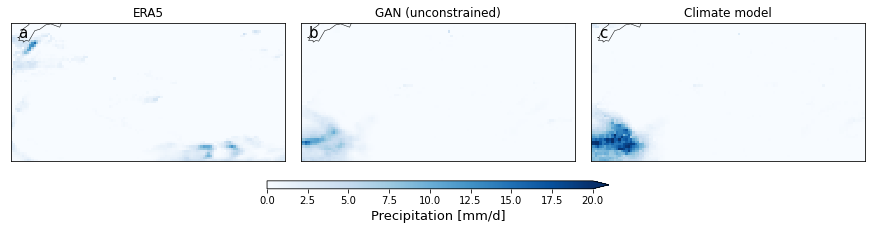

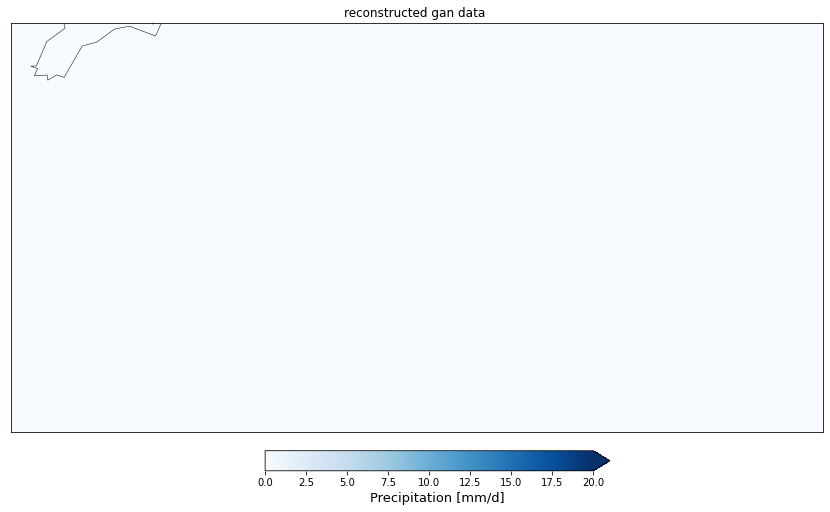

In [56]:
chose_day=1
PlotAnalysis(test_data).single_frames(projection="cyl",time_index=chose_day)
plot_reconstruction(reconstruct_data,projection="cyl",time_index= chose_day)

## Plot single frames

set the chose_day parameter to plot the precipitation on a specific day

In [ ]:
chose_day=10

PlotAnalysis(test_data).single_frames(time_index=chose_day)
PlotAnalysis(test_data).single_frames(projection="cyl",time_index=chose_day)

## plot of the average test_data for each data

In [ ]:
PlotAnalysis(test_data).avg_frames(projection="cyl",scale_precip_by = 10)

## plot of the average **errors** between era5 & gan / climate_model

In [ ]:
PlotAnalysis(test_data).avg_frames_abs_err(projection="cyl", scale_precip_by = 20)

**TODO**: plot spatial plot - mean Error - also show lands

# Plot **histogram** statistics

## histogram no log

Here we plot the histogram over the daily precipitation values in the test dataset. 

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(4, 4),  constrained_layout=True)

PlotAnalysis(test_data).histograms(single_plot=False, ax=ax, show_legend=True, annotate=True,log=False,xlim_end=30)

## histogram log on **density**

Because it is hard to see anything because precipitations over 50 are very rare and thus the 3 plots are right above eachother, we apply the log to the probability desnity to better see the differences.

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6, 6),  constrained_layout=True)

PlotAnalysis(test_data).histograms(single_plot=False, ax=ax, show_legend=True, annotate=True,log=True)

## plot histogram log density **differences**

days in the test_data set

In [ ]:
len(getattr(test_data,"gan").time)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6, 6),  constrained_layout=True)

PlotAnalysis(test_data).histogram_diff(single_plot=False, ax=ax, show_legend=True, annotate=True)

## plot log **precipitation**

Applying the **log** to the data itself instead of to the amount of points in the bins as in the plot before results in the density to be on one scale:

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6, 6),  constrained_layout=True)
PlotAnalysis(test_data).log_histograms(single_plot=False, ax=ax, show_legend=True, annotate=True)

## plot histogram log precipitation differences

In [ ]:
PlotAnalysis(test_data).log_histogram_diff(single_plot=False, ax=ax, show_legend=True, annotate=True)

# Plot **latitudinal** **mean**

In [ ]:
PlotAnalysis(test_data).latitudinal_mean()

# Further Evaluation methods

In [ ]:
#from Bias_GAN.code.src.plots import plot_gan_ensemble
#plot_gan_ensemble()

# SSIM comparison

In [ ]:
from skimage.metrics import structural_similarity as ssim

# Open the .nc file
data_gan = xr.open_dataset(f'/content/gdrive/MyDrive/bias_gan/results/{version_}/gan.nc').gan_precipitation
data_era5 = xr.open_dataset(f"/content/gdrive/MyDrive/bias_gan/data_gan/pr_W5E5v2.0_regionbox_era5_1979-2014.nc").era5_precipitation #*3600*24 
data_model = xr.open_dataset(f"/content/gdrive/MyDrive/bias_gan/data_gan/pr_gfdl-esm4_historical_regionbox_1979-2014.nc").precipitation #*3600*24 

# Extract the data you want to calculate SSIM for
gan_values = data_gan.values
era5_values = data_era5.values
model_values = data_model.values

calculate the SSIM for the gan only for 4018 entries bc thats the size of the test dataset

SSIM for the climate model

In [ ]:
# Calculate SSIM
model_score, model_diff = ssim(era5_values[-4018:,:,:], model_values[-4018:,:,:], full=True)
print("model score:", model_score)

SSIM for the GAN

In [ ]:
gan_score, gan_diff = ssim(era5_values[-4018:,:,:], gan_values, full=True)
print("gan score:", gan_score)

In [ ]:
gan_values.shape,era5_values.shape,model_values.shape

# Compare metrics

In [ ]:
"""
instances = ["2023_01_11_13h_04m_08s","2023_01_12_05h_34m_48s","2023_01_12_07h_34m_09s","2023_01_13_07h_17m_53s", "2023_01_13_11h_06m_15s","2023_01_14_08h_45m_11s"]

for i in instances: 
    evaluation_instance = i
    checkpoint_path = f"/content/gdrive/MyDrive/bias_gan/results/{evaluation_instance}/last.ckpt" 
    config_path = f"/content/gdrive/MyDrive/bias_gan/results/{evaluation_instance}/config_model.json"
    data = EvaluateCheckpoints(checkpoint_path=checkpoint_path, config_path=config_path, save_model=True)
    data.run()
    test_data = data.get_test_data()
    print("")
    PlotAnalysis(test_data).avg_frames_abs_err(projection="cyl", scale_precip_by = 10)
    print("")
    PlotAnalysis(test_data).latitudinal_mean()
    print("")
"""

# Data

# raw output
# check whats available in isimip


# do we use the right data? the already bias corrected data (also with downscaling)

# downscaled climate model

In [ ]:
# 1. remove all trends and add again at the end !!!
# 2. 